Import libraries:

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import numpy as np
from numpy import random
import math
import scipy
from scipy import stats
from random import choice
import networkx as nx
import json
from networkx.readwrite import json_graph
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [21]:
import findspark
import os
findspark.init()
import pyspark
sc = pyspark.SparkContext()

Load graph & related functions:

In [2]:
with open("graph/nc_mini.json", "r") as graph_data:
    graph_data = json.load(graph_data)
    NC_digraph = json_graph.node_link_graph(graph_data)

In [3]:
# Function to print graph
def print_graph(Graph, S1=None):
    plt.figure(figsize=(16,10))
    color_map = {1: 'b', 0: 'r'}
    pos = nx.random_layout(Graph)
    
    if S1:
        nx.draw_networkx(Graph, pos, with_labels=False, node_size=100, node_shape='.',
                linewidth=None, width=0.2, edge_color='y', 
                node_color=[color_map[Graph.node[node]['action']] for node in Graph],
                edgelist=reduce(lambda x,y: x+y,[Graph.edges(node) for node in S1]))
        nx.draw_networkx_nodes(Graph, pos, nodelist=S1, node_color="b", node_size=150, 
                              node_shape="*", label="Initial Set")
        plt.legend()
    else:
        nx.draw_networkx(Graph, pos, with_labels=False, node_size=100, node_shape='.',
                linewidth=None, width=0.2, edge_color='y', 
                 node_color=[color_map[Graph.node[node]['action']] for node in Graph])
        
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Part 1: Influence function:

### Single start node

In [4]:
def activateNodes(detStart, detRandSeed):

    nx.set_node_attributes(NC_digraph, 'activated', False)
    nx.set_node_attributes(NC_digraph, 'explored', False)
    
    if detStart is None:
        if detRandSeed is not None:
            random.seed()
        start = random.choice(NC_digraph.nodes(), 1)
    else:
        start = detStart
    
    nodes = [start[0]]

    activated = 1
    
    NC_digraph.node[start[0]]['activated'] = True
    
    while len(nodes)>0:

        startNode = nodes[0]

        if NC_digraph.node[startNode]['explored']==False:

            NC_digraph.node[startNode]['explored'] = True

            successors = []

            for succNode in NC_digraph.succ[startNode]:

                if NC_digraph.node[succNode]['activated']==False:

                    alpha = NC_digraph[startNode][succNode]['weight']
                    beta = NC_digraph.node[succNode]['review_count']

                    if detRandSeed is not None:
                        random.seed(detRandSeed)
                    randUnif = random.uniform(0,1)
                    if detRandSeed is not None:
                        random.seed(detRandSeed)
                    randBeta = np.sqrt(random.beta(alpha, beta))

                    if randUnif < randBeta:
                        NC_digraph.node[succNode]['activated'] = True
                        successors.append(succNode)
                        activated = activated + 1

        nodes = nodes[1:]
        nodes = nodes + successors

    return activated

def activateNodesLoop(N, rootSeed=None, randNumSeed=None):
    
    if rootSeed is not None and randNumSeed is not None:
        random.seed(rootSeed) 
        detStart = random.choice(NC_digraph.nodes(), 1) # deterministic start node
        detRandSeed = randNumSeed # deterministic random variables
    elif rootSeed is None and randNumSeed is None:
        random.seed()
        detStart = None # stochastic start node
        detRandSeed = None # stochastic random variables
    elif rootSeed is not None and randNumSeed is None:
        random.seed(rootSeed) 
        detStart = random.choice(NC_digraph.nodes(), 1) # deterministic start node
        random.seed()
        detRandSeed = None # stochastic random variables
    elif rootSeed is None and randNumSeed is not None:
        detStart = None # stochastic start node
        detRandSeed = randNumSeed # deterministic random variables

    result = []

    for n in xrange(N):
        result.append(float(activateNodes(detStart, detRandSeed)))
        
    return result

#### Checking function behavior:

1) Test results with given starting parameters:

In [5]:
assert activateNodesLoop(N=1, rootSeed=9, randNumSeed=9)[0] == 141
assert activateNodesLoop(N=1, rootSeed=12, randNumSeed=12)[0] == 1
assert activateNodesLoop(N=1, rootSeed=24, randNumSeed=12)[0] == 4

2) Test mean and standard deviation (should be ~9.5 and ~14):

10.539000 mean, 15.478646 standard deviation


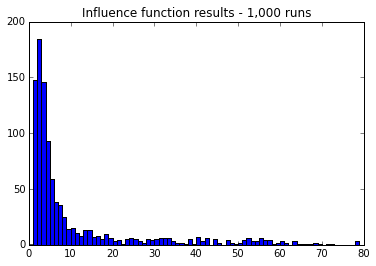

In [32]:
result = activateNodesLoop(N=1000, rootSeed=24, randNumSeed=None)
print '%f mean, %f standard deviation' % (np.mean(result), np.std(result))
plt.hist(result, bins=range(int(max(result))))
plt.title('Influence function results - 1,000 runs')
plt.show()

3) Check runtime and profile code:

In [7]:
%time result = activateNodesLoop(N=1000, rootSeed=24, randNumSeed=None)

CPU times: user 690 ms, sys: 13.6 ms, total: 704 ms
Wall time: 1.12 s


In [10]:
%lprun -f activateNodes result = activateNodesLoop(N=1000, rootSeed=24, randNumSeed=None)

4) Determine standard error as a function of N: 

In [12]:
# Saved results loaded below
# stdErr = dict()
# stdErr = {i: 0 for i in range(100,1150,50)}

# for k in stdErr.keys():
#     results = []
#     for i in xrange(100):
#         results.append(np.mean(activateNodesLoop(N=int(k), rootSeed=24, randNumSeed=None)))
#     fd = open("data/SE-NC_mini-N=" + str(k) + ".json","w")
#     json.dump(results, fd)
#     fd.close()
#     del results

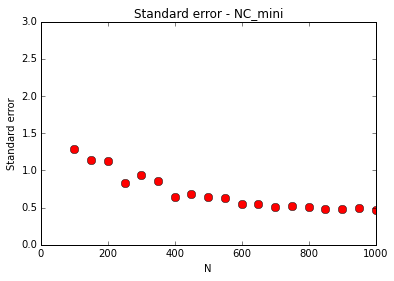

In [79]:
stdErrMini = dict()

for k in range(100,1050,50):

    with open("data/SE-NC_mini-N=" + str(k) + ".json", "r") as fd:
        results = json.load(fd)
        
    stdErrMini[k] = np.std(results)
    
plt.plot(stdErrMini.keys(), stdErrMini.values(), 'o-', color='r', linestyle='None', markersize=8)
plt.title('Standard error - NC_mini')
plt.xlabel('N')
plt.ylabel('Standard error')
plt.xlim(xmin=0, xmax=1000)
plt.ylim(ymin=0, ymax=3)
plt.show()

In [80]:
yMini = [math.log(i) for i in stdErrMini.values()]
xMini = [math.log(i) for i in stdErrMini.keys()]
slopeMini, interceptMini, r_valueMini, p_valueMini, std_errMini = scipy.stats.linregress(xMini, yMini)
print 'lambda = %f' % (-slopeMini)
print 'alpha = %f' % (math.exp(interceptMini))

lambda = 0.490183
alpha = 13.485154


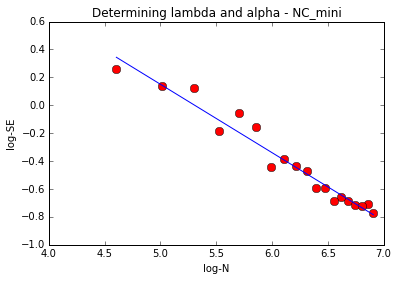

In [92]:
keys = [math.log(i) for i in stdErrMini.keys()]
keys.sort()
solution = [interceptMini + slopeMini*n for n in keys]

plt.plot(xMini, [math.log(i) for i in stdErrMini.values()], 'o-', color='r', linestyle='None', markersize=8)
plt.plot(keys, solution)
plt.title('Determining lambda and alpha - NC_mini')
plt.xlabel('log-N')
plt.ylabel('log-SE')
plt.xlim(xmin=4, xmax=7)
plt.ylim(ymin=-1, ymax=0.6)
plt.show()

5) Repeat the same excercise for the NC_full graph:

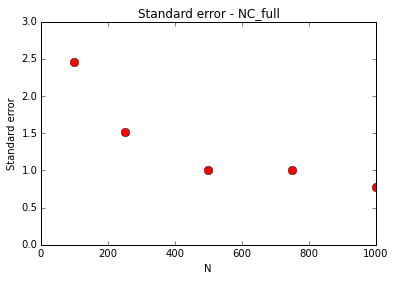

In [83]:
plot_range = [100,250,500,750,1000]

stdErrFull = dict()

for k in plot_range:

    with open("data/SE-NC_full-N=" + str(k) + ".json", "r") as fd:
        results = json.load(fd)
        
    stdErrFull[k] = np.std(results)
    
plt.plot(stdErrFull.keys(), stdErrFull.values(), 'o-', color='r', linestyle='None', markersize=8)
plt.title('Standard error - NC_full')
plt.xlabel('N')
plt.ylabel('Standard error')
plt.xlim(xmin=0, xmax=1000)
plt.ylim(ymin=0, ymax=3)
plt.show()

In [85]:
yFull = [math.log(i) for i in stdErrFull.values()]
xFull = [math.log(i) for i in stdErrFull.keys()]
slopeFull, interceptFull, r_valueFull, p_valueFull, std_errFull = scipy.stats.linregress(xFull, yFull)
print 'lambda = %f' % (-slopeFull)
print 'alpha = %f' % (math.exp(interceptFull))

lambda = 0.479969
alpha = 21.769997


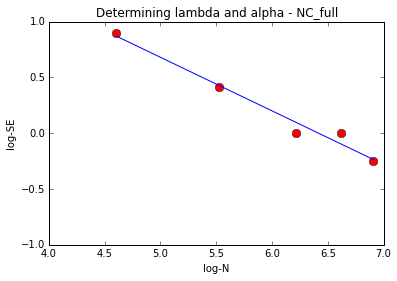

In [89]:
keys = [math.log(i) for i in stdErrFull.keys()]
keys.sort()
solution = [interceptFull + slopeFull*n for n in keys]

plt.plot(xFull, [math.log(i) for i in stdErrFull.values()], 'o-', color='r', linestyle='None', markersize=8)
plt.plot(keys, solution)
plt.title('Determining lambda and alpha - NC_full')
plt.xlabel('log-N')
plt.ylabel('log-SE')
plt.xlim(xmin=4, xmax=7)
plt.ylim(ymin=-1, ymax=1)
plt.show()

### Multiple start nodes

In [35]:
def activateNodesOptSN(detStartNodes):

    nx.set_node_attributes(NC_digraph, 'activated', False)
    nx.set_node_attributes(NC_digraph, 'explored', False)
    
    activated = 0
    nodes = []
    
    for n in detStartNodes:
        nodes.append(n)
        NC_digraph.node[n]['activated'] = True
        activated = activated + 1
    
    start = nodes[0]

    while len(nodes)>0:

        startNode = nodes[0]

        if NC_digraph.node[startNode]['explored']==False:

            NC_digraph.node[startNode]['explored'] = True

            successors = []

            for succNode in NC_digraph.succ[startNode]:

                if NC_digraph.node[succNode]['activated']==False:

                    alpha = NC_digraph[startNode][succNode]['weight']
                    beta = NC_digraph.node[succNode]['review_count']

                    randUnif = random.uniform(0,1)
                    randBeta = np.sqrt(random.beta(alpha, beta))

                    if randUnif < randBeta:
                        NC_digraph.node[succNode]['activated'] = True
                        successors.append(succNode)
                        activated = activated + 1

        nodes = nodes[1:]
        nodes = nodes + successors

    return activated

def activateNodesLoopSN(N, startNodes):
    
    detStartNodes = startNodes
    random.seed()
    
    result = []

    for n in xrange(N):
        result.append(float(activateNodesOptSN(detStartNodes)))
        
    return result

1) Test mean and standard deviation (should be ~13.5 and ~16):

In [17]:
startNodes = ['E6Eh1bz6fpo6EOPtctA-sg', 'VFOwxpOWH9RZ3iMelkRd7A']
result = activateNodesLoopSN(10000, startNodes)
print '%f mean, %f standard deviation' % (np.mean(result), np.std(result))

13.316000 mean, 16.254419 standard deviation


2) Check runtime:

In [18]:
%time result = activateNodesLoopSN(10000, startNodes)

CPU times: user 7.55 s, sys: 56.9 ms, total: 7.61 s
Wall time: 11 s


## Part 2: Greedy algorithm

In [19]:
def activateNodesOptGreedy(detStartNodes):

    activated = set()
    explored = set()

    nodes = []
    
    for n in detStartNodes:
        nodes.append(n)
        activated.add(n)
    
    start = nodes[0]
    
    successors = []

    while len(nodes)>0:

        startNode = nodes[0]

        if startNode not in explored:

            explored.add(startNode)

            successors = []

            for succNode in NC_digraph.succ[startNode]:

                if succNode not in activated:

                    alpha = NC_digraph[startNode][succNode]['weight']
                    beta = NC_digraph.node[succNode]['review_count']

                    randUnif = random.uniform(0,1)
                    randBeta = np.sqrt(random.beta(alpha, beta))

                    if randUnif < randBeta:
                        activated.add(succNode)
                        successors.append(succNode)

        nodes = nodes[1:]
        nodes = nodes + successors

    return len(activated)

def activateNodesLoopGreedy(N, startNodes):
    
    random.seed()
    searchNodes = NC_digraph.nodes()
    actNodeOpt = []
    
    for s in range(startNodes):
        maxActNode = 0
        maxActNodeStart = []

        for n in searchNodes:
            detStartNodes = actNodeOpt + [n]
            result = []
            for r in xrange(N):
                result.append(float(activateNodesOptGreedy(detStartNodes)))
            act = np.mean(result)
            if act>maxActNode:
                maxActNode = act
                maxActNodeStart = n
            
        searchNodes.remove(maxActNodeStart)
        actNodeOpt.append(maxActNodeStart)
    
    return actNodeOpt, maxActNode

1) Check runtime:

In [20]:
%time solNodes, solActivated = activateNodesLoopGreedy(1000, 3)
print 'Optimal nodes: %s\nAverage of %d nodes activated' % (solNodes, solActivated)

CPU times: user 7min 38s, sys: 3.8 s, total: 7min 42s
Wall time: 9min 20s
Optimal nodes: [u'NzWLMPvbEval0OVg_YDn4g', u'VhI6xyylcAxi0wOy2HOX3w', u'ts7EG6Zv2zdMDg29nyqGfA']
Average of 46 nodes activated


2) Run on Spark and compare results for N = 100, 250, 500, 750, 1,000:

In [25]:
# Saved results loaded below
# start = 1
# noRuns = 30
# greedyN = 100
# runs = sc.parallelize(range(start, start + noRuns))
# results = runs.map(lambda x: (x, activateNodesLoopGreedy(greedyN, 3)))
# results_list = results.collect()
# fd = open("data/greedy-" + str(noRuns) + "x-N=" + str(greedyN) + ".json","w")
# json.dump(results_list, fd)
# fd.close()
# del results

In [26]:
noRuns = 30

delta_graph_axis = []
delta_graph_data = []

axis_plot = dict()
results_plot = dict()
f_min = dict()
f_max = dict()

for greedyN in [100, 250, 500, 750, 1000]:
    
    with open("data/greedy-" + str(noRuns) + "x-N=" + str(greedyN) + ".json", "r") as fd:
        results = json.load(fd)
        
    # For delta graph
    actNodes = [r[1][1] for r in results]
    delta_graph_axis.append(greedyN)
    delta_graph_data.append(min(actNodes)/max(actNodes))
    
    # For scatter plot
    axis_plot[greedyN] = [r[0] for r in results]
    results_plot[greedyN] = [r[1][1] for r in results]
    f_min[greedyN] = min(results_plot[greedyN])
    f_max[greedyN] = max(results_plot[greedyN])

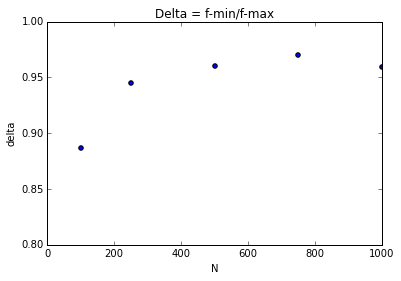

In [27]:
plt.scatter(delta_graph_axis, delta_graph_data)
plt.xlim(0, 1000)
plt.ylim(0.8, 1)
plt.xlabel('N')
plt.ylabel('delta')
plt.title('Delta = f-min/f-max')
plt.show()

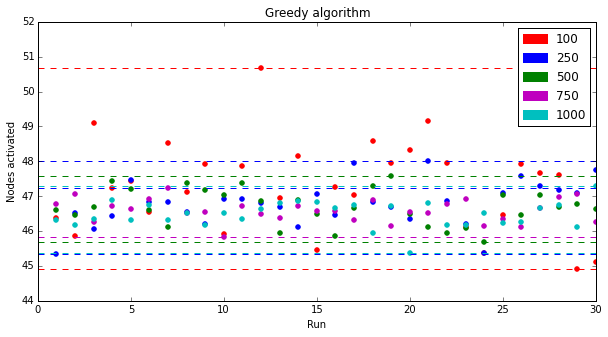

In [30]:
fig = plt.figure(figsize=(10, 5))

# Scatter plots
plt.scatter(axis_plot[100], results_plot[100], color='r')
plt.scatter(axis_plot[250], results_plot[250], color='b')
plt.scatter(axis_plot[500], results_plot[500], color='g')
plt.scatter(axis_plot[750], results_plot[750], color='m')
plt.scatter(axis_plot[1000], results_plot[1000], color='c')

# Min lines
plt.plot([0, 30], [f_min[100], f_min[100]], color='r', ls="--")
plt.plot([0, 30], [f_min[250], f_min[250]], color='b', ls="--")
plt.plot([0, 30], [f_min[500], f_min[500]], color='g', ls="--")
plt.plot([0, 30], [f_min[750], f_min[750]], color='m', ls="--")
plt.plot([0, 30], [f_min[1000], f_min[1000]], color='c', ls="--")

# Max lines
plt.plot([0, 30], [f_max[100], f_max[100]], color='r', ls="--")
plt.plot([0, 30], [f_max[250], f_max[250]], color='b', ls="--")
plt.plot([0, 30], [f_max[500], f_max[500]], color='g', ls="--")
plt.plot([0, 30], [f_max[750], f_max[750]], color='b', ls="--")
plt.plot([0, 30], [f_max[1000], f_max[1000]], color='c', ls="--")

# Legend
N100 = mpatches.Patch(color='r', label='100')
N250 = mpatches.Patch(color='b', label='250')
N500 = mpatches.Patch(color='g', label='500')
N750 = mpatches.Patch(color='m', label='750')
N1000 = mpatches.Patch(color='c', label='1000')
plt.legend(handles=[N100, N250, N500, N750, N1000])

plt.ylim(44, 52)
plt.xlim(0, 30)
plt.xlabel('Run')
plt.ylabel('Nodes activated')
plt.title('Greedy algorithm')

plt.show()

## Part 3: Simulated annealing

In [50]:
def swapnodes(nodes, graph):
    indices = range(len(nodes))
    
    # take a random index to swap from the nodes
    n1 = np.random.choice(indices, 1)
    swapped_node = nodes[n1[0]]
    
    # take a random index to swap from the whole graph
    n2 = np.random.choice(graph.nodes(), 1)
        
    # We check that we are not choosing the same node we just swapped
    while n2 == swapped_node:
        n2 = np.random.choice(graph.nodes(), 1)
    
    nodes[n1] = n2[0]
    
    return nodes

In [51]:
def activateNodesOptSA(detStartNodes):

    explored = set()
    activated = set()
    
    nodes = []
    for node in detStartNodes:
        nodes.append(node)
        activated.add(node)
    
    start = detStartNodes[0]
    successors = []

    while len(nodes)>0:

        startNode = nodes[0]

        if startNode not in explored:

            explored.add(startNode)

            successors = []
            for succNode in NC_digraph.succ[startNode]:

                if succNode not in activated:

                    alpha = NC_digraph[startNode][succNode]['weight']
                    beta = NC_digraph.node[succNode]['review_count']

                    if random.uniform(0,1) < np.sqrt(random.beta(alpha, beta)):
                        if succNode not in explored:
                            activated.add(succNode)
                            successors.append(succNode)

        nodes = nodes[1:]
        nodes = nodes + successors

    return len(activated)

def activateNodesLoopSA(N, startNodes):

    iterations = sc.parallelize(xrange(N), 4)
    activatedNodes = iterations.map(lambda x: (activateNodesOptSA(startNodes)))
    
    return activatedNodes.mean()

In [52]:
def simulated_annealing_tsp(function, initial_X, graph, N, initial_temp, cool, reanneal, iterr):
    
    accepted = 0
    X = initial_X
    T = initial_temp
    
    history = list()
    # Evaluate E
    #print distance(X)
    prev_E = function(N, X)
    history.append(prev_E)
    
    for i in xrange(iterr):
        # Stepsize
        L = int(np.ceil(T))
        # Propose new x1 and x2 - Metropolis Algo.
        X_star = swapnodes(X, graph)
        # Evaluate E
        new_E = function(N, X_star) 
        delta_E = prev_E - new_E
        
        # Flip a coin
        U = np.random.uniform()
        if U < np.exp(-delta_E / T):
            accepted += 1
            history.append(new_E)
            # Copy X_star to X
            X = X_star
            prev_E = new_E

        # Check to cool down
        if accepted % reanneal == 0:
            T *= cool
            if T < 0.001: # Reheat
                T = 2.
            
    return X, history

In [53]:
startNodes = random.choice(NC_digraph.nodes(),3)
initial_temp = 2.0
cool = 0.9
reanneal = 100
iterr = 1000
N = 500
path, history = simulated_annealing_tsp(activateNodesLoopSA, startNodes, NC_digraph, N,  initial_temp, cool, reanneal, iterr)

[u'glzRad3_l42hALvjB9p97w' u'T7eyOatIKKQyW9WopkKI9w'
 u'ED6n40WmZJm0AvsKkG7iaw']


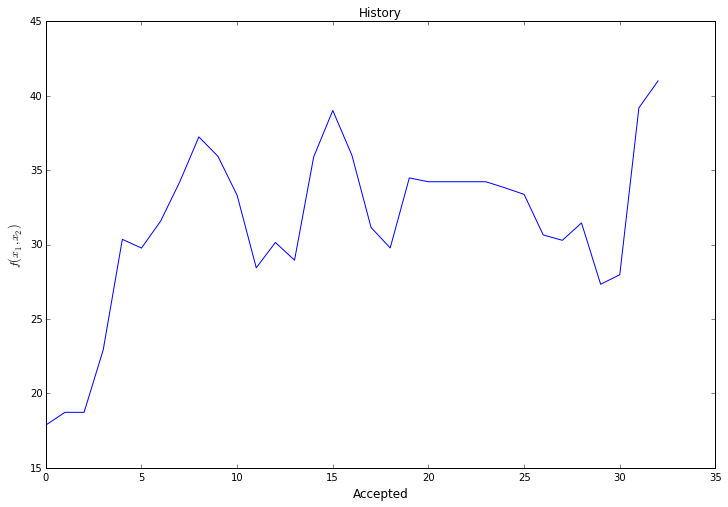

In [54]:
print path
plt.figure(figsize=(12,8))
plt.plot(history)
plt.title("History")
plt.ylabel("$f(x_1,x_2)$",fontsize=12)
plt.xlabel("Accepted", fontsize=12)
plt.show()